In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model


import warnings

# Ignorer tous les avertissements
warnings.filterwarnings("ignore")



C:\Users\bouch\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bouch\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\bouch\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Chargement et Exploration des Données Boursières depuis un Fichier Excel

In [2]:
# Charger le fichier Excel
excel_file_path = 'Historiques_cours_boursiers.xlsx'
xls = pd.ExcelFile('Historiques_cours_boursiers.xlsx')

# Lire chaque onglet dans une boucle
dataframes = {}  # Utiliser un dictionnaire pour stocker les DataFrames de chaque onglet

for sheet_name in xls.sheet_names:
    # Lire les données de l'onglet en cours
    df = pd.read_excel(excel_file_path, sheet_name)
    
    # Stocker le DataFrame dans le dictionnaire
    dataframes[sheet_name] = df

# Accéder à un DataFrame spécifique (par exemple, le premier onglet)
premier_onglet = dataframes[xls.sheet_names[0]]



Ce code charge un fichier Excel contenant des données boursières, lit chaque onglet du fichier Excel dans un DataFrame distinct, puis stocke ces DataFrames dans un dictionnaire.

6 indices boursiers parmi les 13

In [3]:
#6 choix 

list_choice= {'MSFT_df':dataframes[xls.sheet_names[9]],
              'AMZN_df' :dataframes[xls.sheet_names[12]],
              'TSLA_df':dataframes[xls.sheet_names[4]],
            'RMSPA_df':dataframes[xls.sheet_names[3]],
              'GE_df':dataframes[xls.sheet_names[2]],
            'TTE_df':dataframes[xls.sheet_names[1]]}

Tailles des fichiers

In [4]:
# Récupérer les noms des DataFrames et leurs tailles
df_sizes = {name: df.shape[0] for name, df in list_choice.items()}

# Afficher la taille de chaque DataFrame en texte
for name, size in df_sizes.items():
    print(f"La taille de {name} est {size} lignes.")


La taille de MSFT_df est 6031 lignes.
La taille de AMZN_df est 6031 lignes.
La taille de TSLA_df est 3394 lignes.
La taille de RMSPA_df est 6165 lignes.
La taille de GE_df est 6031 lignes.
La taille de TTE_df est 6031 lignes.


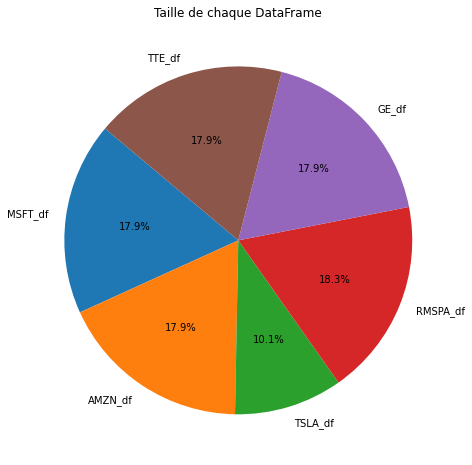

In [5]:
df_names = list(list_choice.keys())
df_sizes = [df.shape[0] for df in list_choice.values()]

# Créer un diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(df_sizes, labels=df_names, autopct='%1.1f%%', startangle=140)
plt.title('Taille de chaque DataFrame')
plt.show()

Microsoft, Amazon, General Electric et Hermès présentent un nombre équivalent de lignes, soit 5967, tandis que Tesla comporte 3330 lignes.

## 1. Data preparation

In [6]:
for key, df in list_choice.items():
 
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

### 2. Exploratory Data Analysis

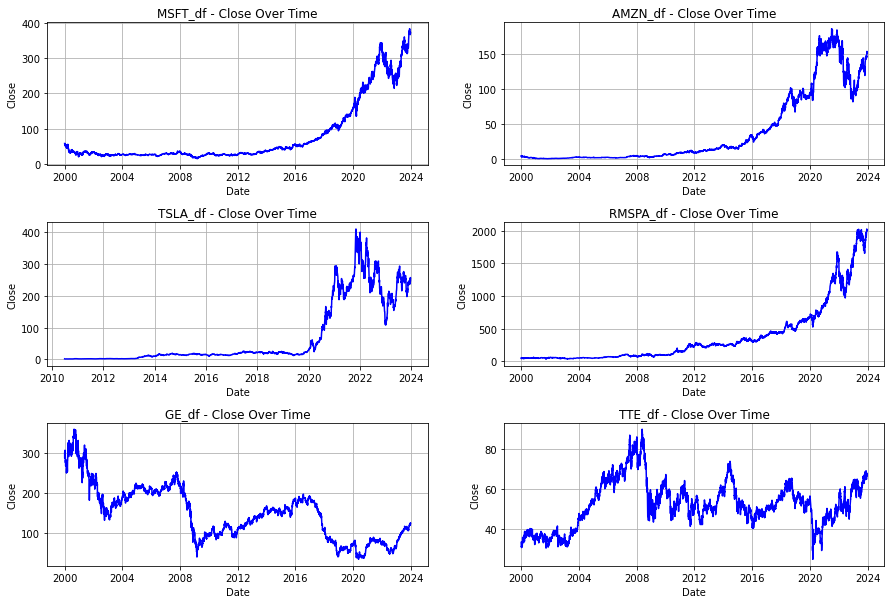

In [7]:
import matplotlib.pyplot as plt

# Nombre total de sous-plots
num_plots = len(list_choice)

# Définir le nombre de lignes et de colonnes dans la grille
num_rows = 3
num_cols = 2

# Créer la grille de sous-plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4)

# Parcourir chaque DataFrame dans la liste
for idx, (df_name, df) in enumerate(list_choice.items()):
    # Convertir la colonne 'Date' en un tableau NumPy
    dates = df['Date'].to_numpy()

    # Convertir la colonne 'Adj Close' en un tableau NumPy
    close = df['Close'].to_numpy()
    opens=df['Open'].to_numpy()
    # Calculer les indices de ligne et de colonne
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    # Tracer le graphique pour le DataFrame actuel dans le sous-plot correspondant
    axes[row_idx, col_idx].plot(dates, close, label='Close',color='blue')
#     axes[row_idx, col_idx].plot(dates, opens, label='Open', color='blue')
    axes[row_idx, col_idx].set_title(f'{df_name} - Close Over Time')
    axes[row_idx, col_idx].set_xlabel('Date')
    axes[row_idx, col_idx].set_ylabel('Close')
    axes[row_idx, col_idx].grid(True)

# Afficher la grille de sous-plots
plt.show()



La trajectoire des valeurs de clôture varie considérablement d'un groupe à l'autre. Certains, tels que Microsoft, Amazon et Hermès, initient leur évolution entre 0 et 100 au cours de la période de 2000 à 2016. En revanche, Tesla commence sa série chronologique en 2010.

L'analyse graphique met en évidence que l'évolution des cours de clôture est propre à chaque groupe. Chaque titre exhibe des tendances et des comportements uniques au fil du temps.


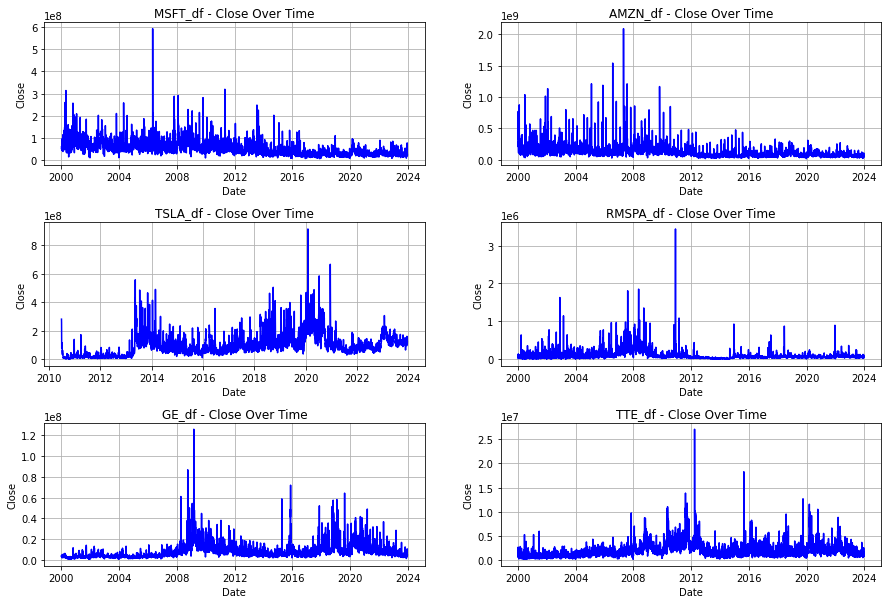

In [8]:
import matplotlib.pyplot as plt

# Nombre total de sous-plots
num_plots = len(list_choice)

# Définir le nombre de lignes et de colonnes dans la grille
num_rows = 3
num_cols = 2

# Créer la grille de sous-plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4)

# Parcourir chaque DataFrame dans la liste
for idx, (df_name, df) in enumerate(list_choice.items()):
    # Convertir la colonne 'Date' en un tableau NumPy
    dates = df['Date'].to_numpy()

    # Convertir la colonne 'Adj Close' en un tableau NumPy
    volume = df['Volume'].to_numpy()
 
    # Calculer les indices de ligne et de colonne
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    # Tracer le graphique pour le DataFrame actuel dans le sous-plot correspondant
    axes[row_idx, col_idx].plot(dates, volume, label='Volume',color='blue')
#     axes[row_idx, col_idx].plot(dates, opens, label='Open', color='blue')
    axes[row_idx, col_idx].set_title(f'{df_name} - Close Over Time')
    axes[row_idx, col_idx].set_xlabel('Date')
    axes[row_idx, col_idx].set_ylabel('Close')
    axes[row_idx, col_idx].grid(True)

# Afficher la grille de sous-plots
plt.show()


### var à expliquer 

In [9]:
def calculate_trend(close_prices):
    # Initialize the target column with neutral values
    target = pd.Series(index=close_prices.index, dtype=int).fillna(0)

# Calculate the percentage change between the current closing price and the closing price five days later
    pct_change = 100 * (close_prices.shift(-5) - close_prices) / close_prices

# Determine the trend
    target[pct_change > 2] = 1  # Bullish trend
    target[pct_change < -2] = -1  # Bearish trend

# Return the target series
    return target.iloc[:-5].astype(int)







In [10]:

for key, df in list_choice.items():
    # Extraire la colonne 'Close' comme une série
    close_prices = df['Close']
    
    # Utiliser la fonction calculate_trend
    trend = calculate_trend(close_prices)
    
    # Ajouter la colonne 'Trend' au DataFrame
    df['Trend'] = trend
    
    # Afficher le DataFrame avec la colonne 'Trend'
#     print(f"\nDataFrame {key} avec la colonne 'Trend':")
#     print(df)

In [11]:
list_choice['MSFT_df'].head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Trend
0,2000-01-03,58.687500,59.31250,56.00000,58.28125,36.132240,53228400,3,1,2000,-1.0
1,2000-01-04,56.781250,58.56250,56.12500,56.31250,34.911697,54119000,4,1,2000,-1.0
2,2000-01-05,55.562500,58.18750,54.68750,56.90625,35.279823,64059600,5,1,2000,-1.0
3,2000-01-06,56.093750,56.93750,54.18750,55.00000,34.098007,54976600,6,1,2000,0.0
4,2000-01-07,54.312500,56.12500,53.65625,55.71875,34.543606,62013600,7,1,2000,0.0
5,2000-01-10,56.718750,56.84375,55.68750,56.12500,34.795467,44963600,10,1,2000,1.0
6,2000-01-11,55.750000,57.12500,54.34375,54.68750,33.904270,46743600,11,1,2000,-1.0
7,2000-01-12,54.250000,54.43750,52.21875,52.90625,32.799969,66532400,12,1,2000,0.0
8,2000-01-13,52.187500,54.31250,50.75000,53.90625,33.419930,83144000,13,1,2000,-1.0
9,2000-01-14,53.593750,56.96875,52.87500,56.12500,34.795467,73416400,14,1,2000,-1.0


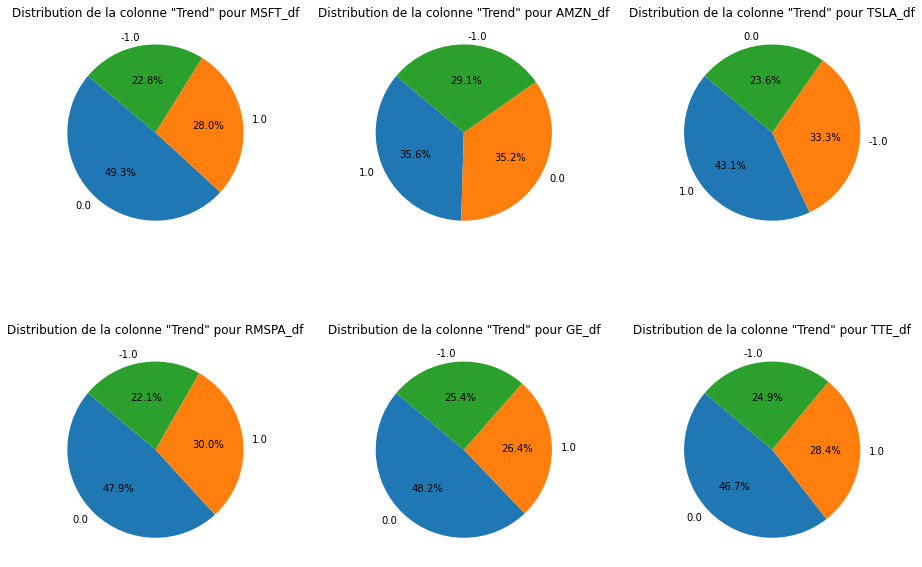

In [12]:
import matplotlib.pyplot as plt

# Définir le nombre de colonnes dans la grille
num_cols = 3

# Calculer le nombre de lignes nécessaire en fonction de la longueur de list_choice
num_rows = -(-len(list_choice) // num_cols)  # Utilisation de la division entière pour arrondir vers le haut

# Créer une grille de sous-graphiques
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Ajuster l'espacement entre les sous-graphiques
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Parcourir chaque dataframe dans list_choice
for i, (key, df) in enumerate(list_choice.items()):
    # Calculer les indices de la ligne et de la colonne pour placer le pie chart
    row_idx = i // num_cols
    col_idx = i % num_cols
#     trend_counts = df['Trend'].to_numpy()
    # Sélectionner le sous-graphique correspondant dans la grille
    ax = axs[row_idx, col_idx] if num_rows > 1 else axs[col_idx]
    trend_counts = df['Trend'].value_counts()
    # Créer le pie chart pour la distribution de la colonne 'Trend'
    ax.pie(df['Trend'].value_counts(), labels=trend_counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Distribution de la colonne "Trend" pour {key}')

# Afficher les sous-graphiques
plt.show()


## Variables explicatives

In [13]:
# Définir les périodes N
N_14 = 14
N_21 = 21
N_ATR = 14
N_CMF_21 = 21
N_CMF_28 = 28

# Seuil pour CMF
seuil_haussier = 0.25
seuil_baissier = -0.25

# Fonction pour calculer RSI
def calculate_rsi(data, period):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi_column = 100 - (100 / (1 + rs))
    return rsi_column

# Fonction pour calculer RSI trend
def calculate_rsi_trend(rsi_column, overbought=70, oversold=30):
    return np.where((rsi_column > overbought), 1, np.where((rsi_column < oversold), -1, 0))

# Fonction pour calculer CMF
def calculate_cmf(data, period):
    mf_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    mf_volume = mf_multiplier * data['Volume']
    cmf_column = mf_volume.rolling(window=period).sum() / data['Volume'].rolling(window=period).sum()
    return cmf_column

# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():
    # Calculer MACD
    df['MACD_Line'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD_Line'] - df['MACD_Signal']
    df['MACD_trend'] = np.where((df['MACD_Line'] > 0) | (df['MACD_Histogram'] > 0), 1,
                                np.where((df['MACD_Line'] < 0) | (df['MACD_Histogram'] < 0), -1, 0))

    # Calculer RSI et les tendances pour chaque période
    df['RSI_14'] = calculate_rsi(df['Close'], N_14)
    df['RSI_trend_14'] = calculate_rsi_trend(df['RSI_14'])

    df['RSI_21'] = calculate_rsi(df['Close'], N_21)
    df['RSI_trend_21'] = calculate_rsi_trend(df['RSI_21'])

    # Calculer ATR
    tr = pd.DataFrame(index=df.index)
    tr['HL'] = df['High'] - df['Low']
    tr['HC'] = abs(df['High'] - df['Close'].shift())
    tr['LC'] = abs(df['Low'] - df['Close'].shift())
    tr['TrueRange'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    df['ATR'] = tr['TrueRange'].rolling(window=N_ATR).mean()

    # Calculer CMF
    df['CMF_21'] = calculate_cmf(df, N_CMF_21)
    df['CMF_28'] = calculate_cmf(df, N_CMF_28)

    # Ajouter la colonne cmf_trend
    df['cmf_trend_21'] = np.where(df['CMF_21'] > seuil_haussier, 1,
                                   np.where(df['CMF_21'] < seuil_baissier, -1, 0))

    df['cmf_trend_28'] = np.where(df['CMF_28'] > seuil_haussier, 1,
                                   np.where(df['CMF_28'] < seuil_baissier, -1, 0))

    # Calculer Daily Range
    df['Daily_Range'] = df['High'] - df['Low']

    # Calculer Gap
    df['Gap'] = df['Open'] - df['Close'].shift(1)

    df.dropna(inplace=True)
    # Afficher le DataFrame avec les nouvelles colonnes
#     print(f"\nDataFrame {key} avec les nouvelles colonnes:")
#     print(df)


In [14]:
list_choice['MSFT_df']

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,...,RSI_trend_14,RSI_21,RSI_trend_21,ATR,CMF_21,CMF_28,cmf_trend_21,cmf_trend_28,Daily_Range,Gap
27,2000-02-10,51.945313,53.281250,51.250000,53.000000,32.858070,54527800,10,2,2000,...,0,47.084233,0,2.058036,0.045718,0.014677,0,0,2.031250,-0.054687
28,2000-02-11,52.437500,52.437500,49.562500,49.968750,30.978819,115559000,11,2,2000,...,0,45.134576,0,2.129464,0.002176,-0.044101,0,0,2.875000,-0.562500
29,2000-02-14,50.617188,50.875000,49.531250,49.812500,30.881937,81028600,14,2,2000,...,0,43.024494,0,2.071429,-0.078925,-0.044173,0,0,1.343750,0.648438
30,2000-02-15,49.875000,50.000000,49.062500,49.281250,30.552582,71027600,15,2,2000,...,0,37.627119,0,1.982143,-0.138220,-0.074553,0,0,0.937500,0.062500
31,2000-02-16,49.625000,50.093750,48.562500,48.812500,30.261980,65202600,16,2,2000,...,0,33.372503,0,1.950893,-0.202426,-0.085955,0,0,1.531250,0.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021,2023-12-07,368.230011,371.450012,366.320007,370.950012,370.950012,23118900,7,12,2023,...,0,56.551815,0,6.626428,0.238533,0.304441,0,1,5.130005,-0.569977
6022,2023-12-08,369.200012,374.459991,368.230011,374.230011,374.230011,20144800,8,12,2023,...,0,56.882562,0,6.416426,0.246111,0.317292,0,1,6.229980,-1.750000
6023,2023-12-11,368.480011,371.600006,366.100006,371.299988,371.299988,27708800,11,12,2023,...,0,56.585959,0,6.352855,0.325731,0.331306,1,1,5.500000,-5.750000
6024,2023-12-12,370.850006,374.420013,370.459991,374.380005,374.380005,24838300,12,12,2023,...,0,53.154714,0,6.184285,0.325746,0.340839,1,1,3.960022,-0.449982


### Observation des corrélations

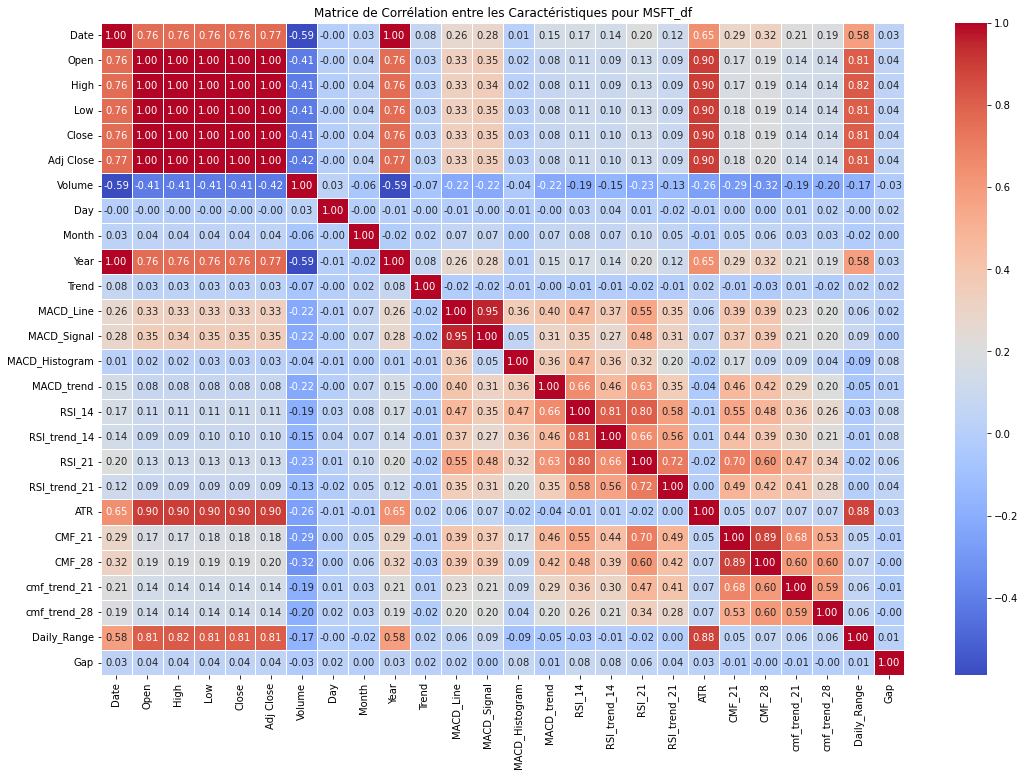

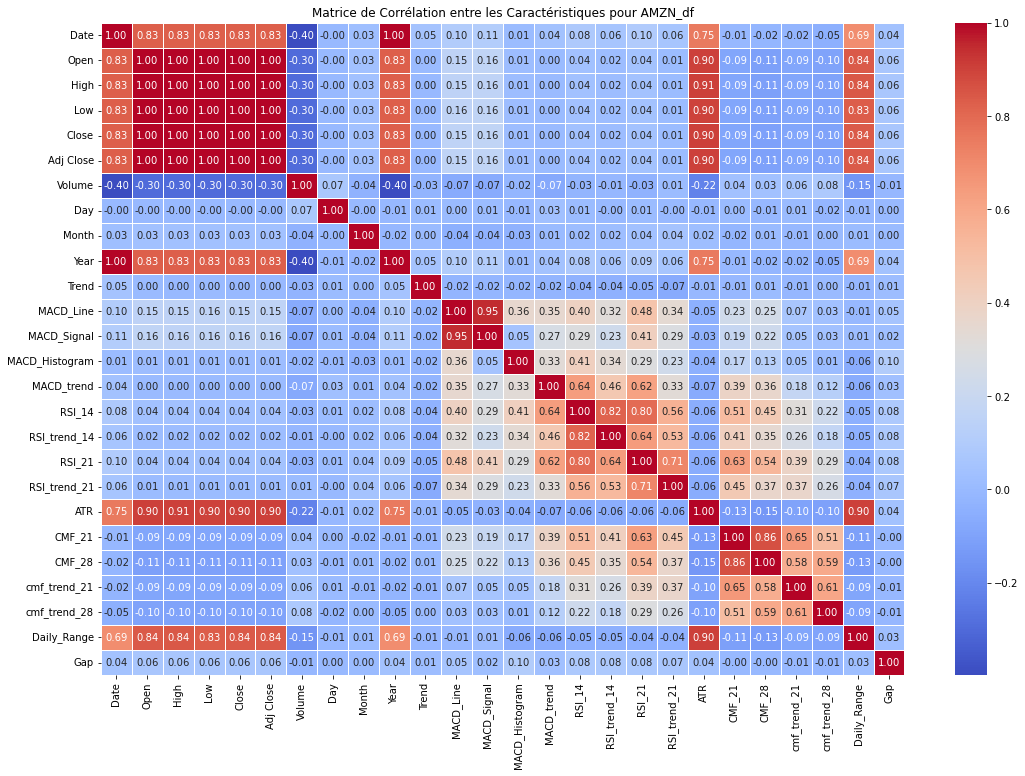

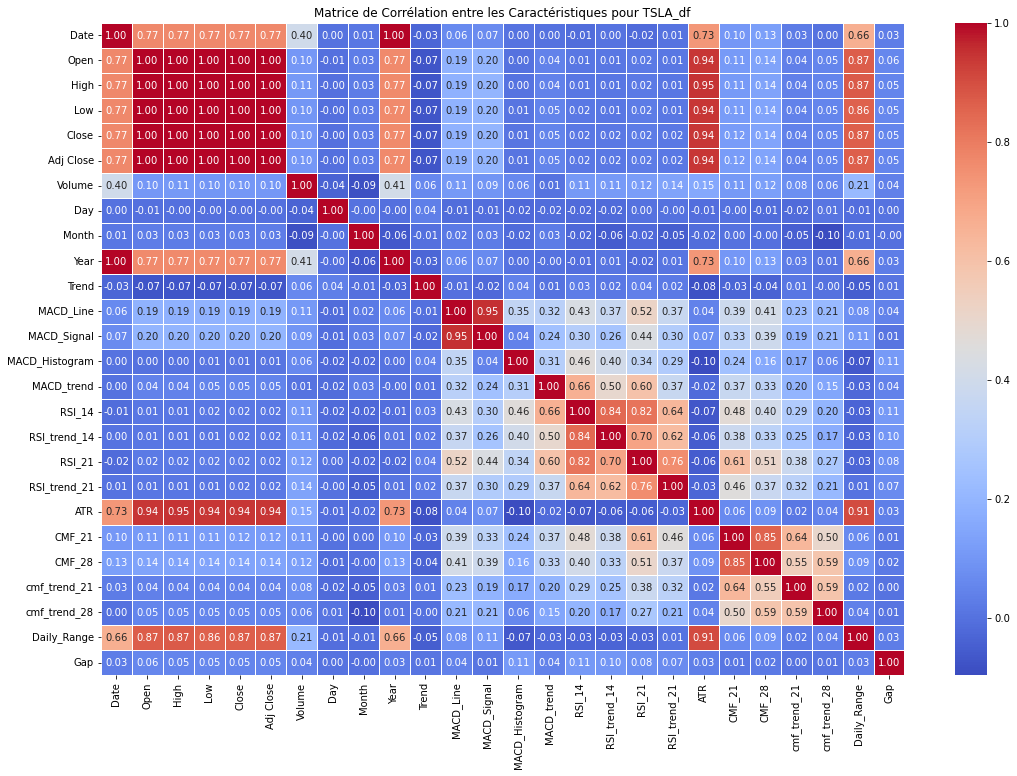

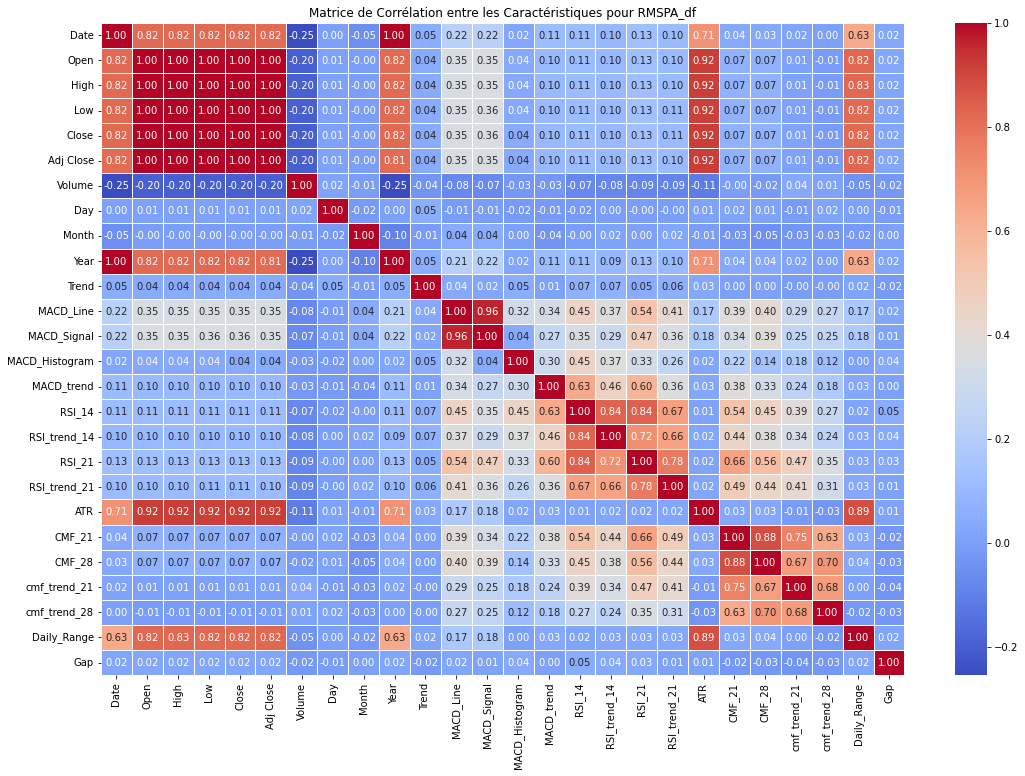

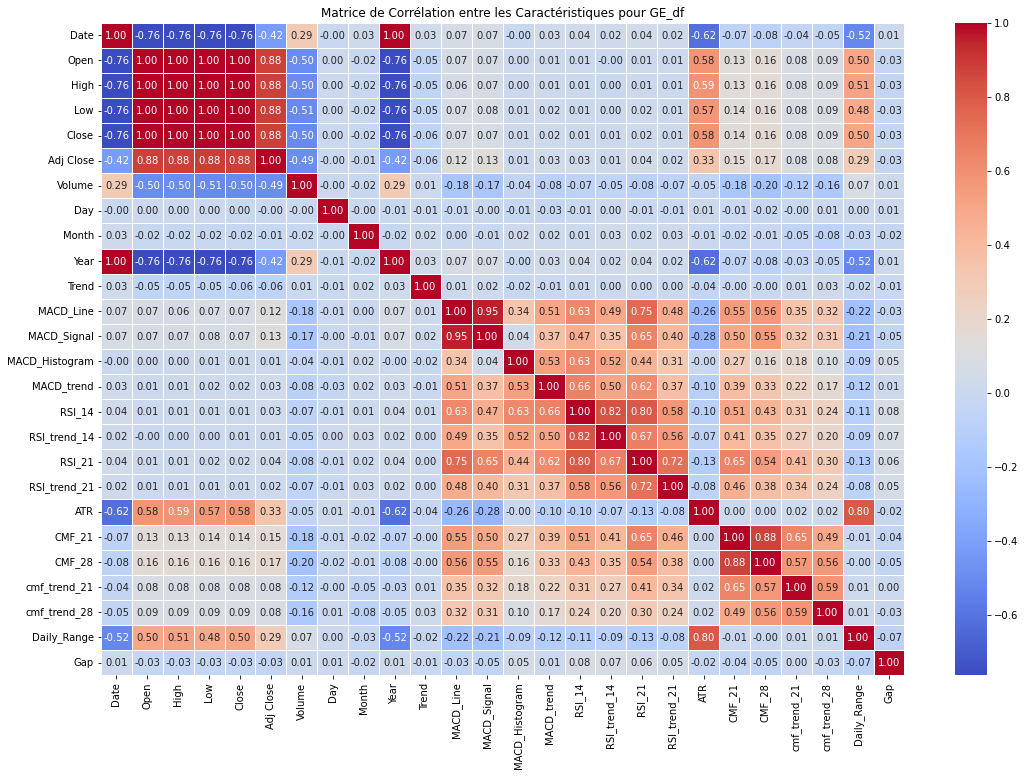

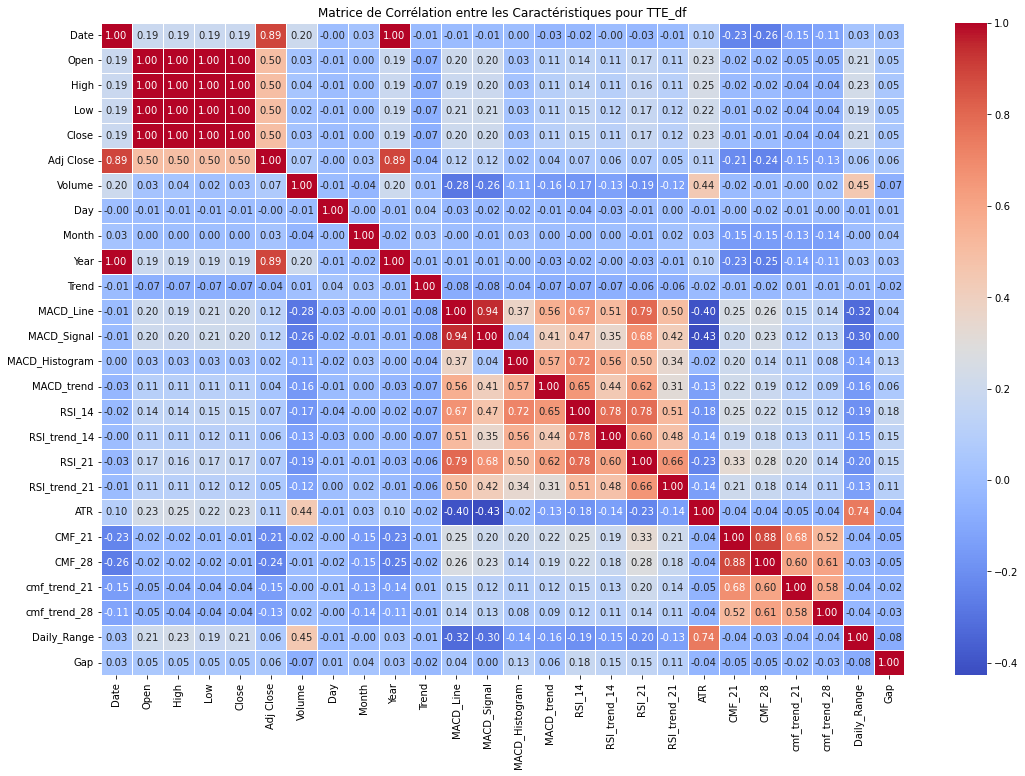

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for key, df in list_choice.items():
    # Calculer la matrice de corrélation
    correlation_matrix = df.corr()

    # Afficher le heatmap de la matrice de corrélation
    plt.figure(figsize=(18, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f"Matrice de Corrélation entre les Caractéristiques pour {key}")  # Utilisez f-string pour incorporer la variable 'key'
    plt.show()


On peut voir une corrélation parfaite (100%) entre les variables High, Open, Low, Close et Adjusted Close. J’ai opté pour  conserver uniquement la variable Close, étant donné qu'elle est spécifiquement utilisée dans le calcul de la tendance.

Analyse de l'indicateur MACD : 
La variable MACD_Line a été retenue, et MACD_Signal a été éliminée en raison de la corrélation presque parfaite entre les deux, évitant ainsi la redondance d'informations.

Choix entre CMF_21 et CMF_28 :
 Les variables CMF_21 et CMF_28 présentaient une corrélation. Conformément à la possibilité mentionnée dans l'énoncé de choisir l'une des deux, CMF_28 a été sélectionnée pour éliminer la redondance d'informations et simplifier le modèle.


### Application de Recursive Feature Elimination (RFE)

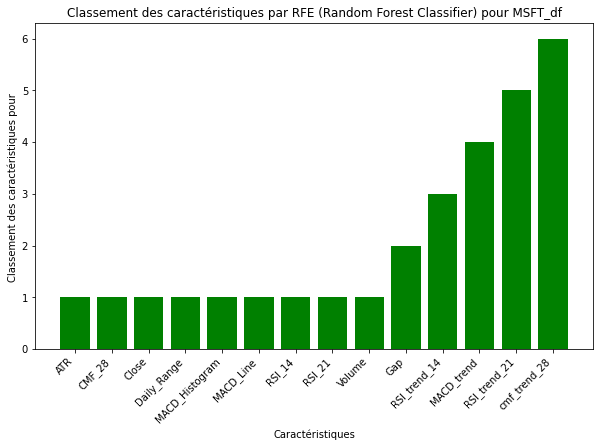

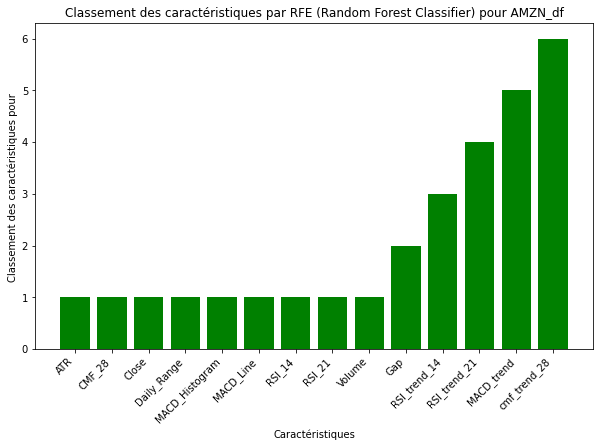

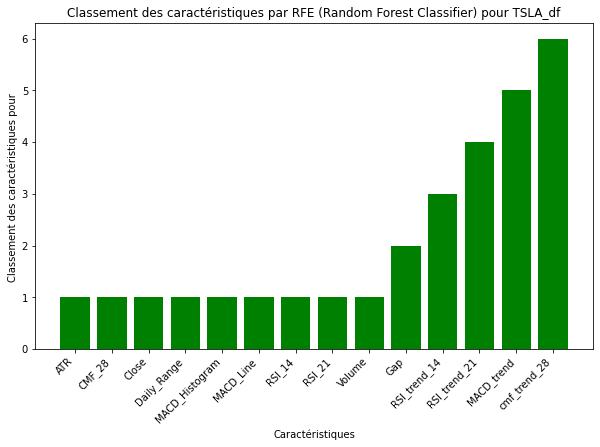

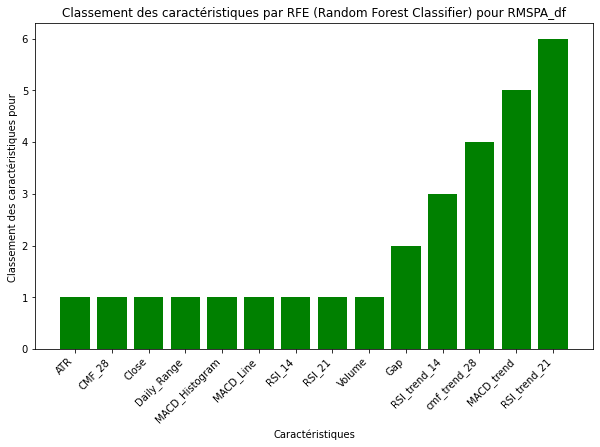

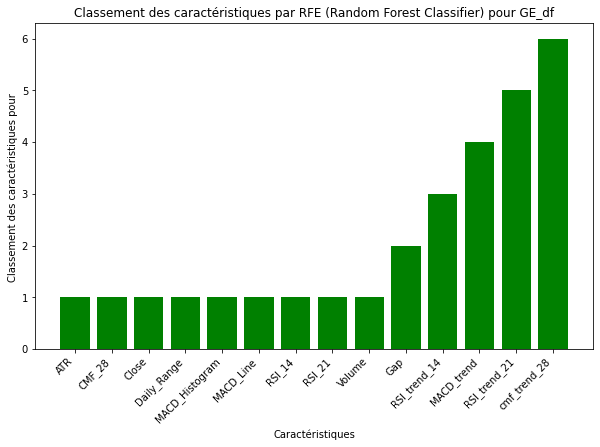

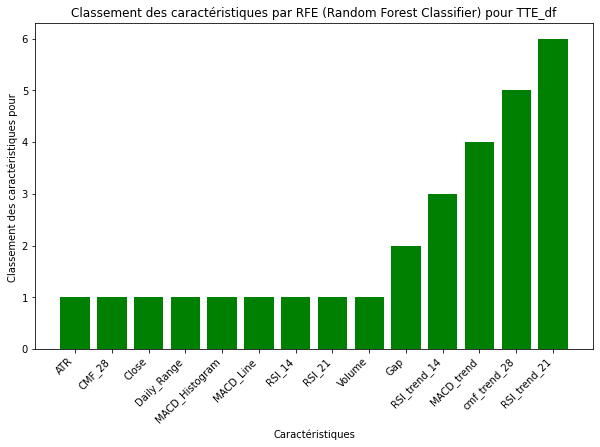

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vos données soient dans un DataFrame 'df'
# Assurez-vous que 'df' contient toutes les colonnes nécessaires, sauf 'Trend' et 'Date'
for key, df in list_choice.items():
    # Définir x comme le DataFrame sans 'Trend' et 'Date'
    x = df.drop(['Trend', 'Date', 'CMF_21', 'Open', 'High', 'cmf_trend_21', 'Low', 'Adj Close', 'Day', 'Month', 'Year', 'MACD_Signal'], axis=1)

    # Définir y comme la colonne 'Trend'
    y = df['Trend']

    # Créer un objet StandardScaler
    scaler = StandardScaler()

    # Normaliser les données x
    x_scaled = scaler.fit_transform(x)

    # Exemple d'utilisation de RFE
    n_features_to_select = 9
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)
    rfe.fit(x_scaled, y)

    # Obtenez les caractéristiques sélectionnées et leur classement
    selected_features = x.columns[rfe.support_]
    ranking = rfe.ranking_

    # Trier les caractéristiques en fonction de leur classement
    sorted_features = [col for _, col in sorted(zip(ranking, x.columns))]

    # Trier les valeurs de classement
    sorted_ranking = sorted(ranking)

    # Créer un graphique à barres
    plt.figure(figsize=(10, 6))

    # Utilisez la fonction `bar` pour créer un graphique à barres verticales
    plt.bar(sorted_features, sorted_ranking, color='green')

    # Ajoutez une annotation pour chaque barre avec la valeur de classement
    plt.xlabel('Caractéristiques')
    plt.ylabel('Classement des caractéristiques pour ')
    plt.title('Classement des caractéristiques par RFE (Random Forest Classifier) pour ' + key)
    plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
    plt.show()



D'aprés RFE , nous allons choisir
[ATR , CMF_21 , CMF_28 , CLOSE , MACD_Histogram , MACD_Line , MACD_Signal , RSI_21, Volume]

In [17]:
selected_features = [ 'ATR','CMF_28', 'Close', 'Daily_Range','MACD_Histogram' , 'MACD_Line' , 'RSI_14', 'RSI_21', 'Volume']

    # Sélectionnez la colonne 'Trend' comme votre variable cible
target_column = 'Trend'



## 8 Différentes modélisations de la variable à expliquer (target)

### 1.  Régression logistique :

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,hamming_loss, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import recall_score, f1_score

In [19]:
!pip install prettytable



**********************************************************************
MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 51.92% |
| Hamming                | 48.08% |
| Macro-average Recall   | 36.91% |
| Macro-average F1 Score | 30.39% |
| Micro-average Recall   | 51.92% |
| Micro-average F1 Score | 51.92% |
+------------------------+--------+


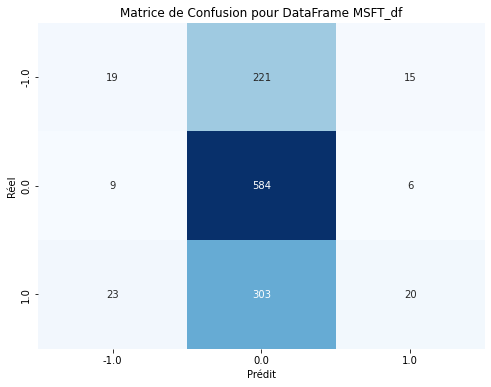


**********************************************************************
AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 39.58% |
| Hamming                | 60.42% |
| Macro-average Recall   | 36.99% |
| Macro-average F1 Score | 35.31% |
| Micro-average Recall   | 39.58% |
| Micro-average F1 Score | 39.58% |
+------------------------+--------+


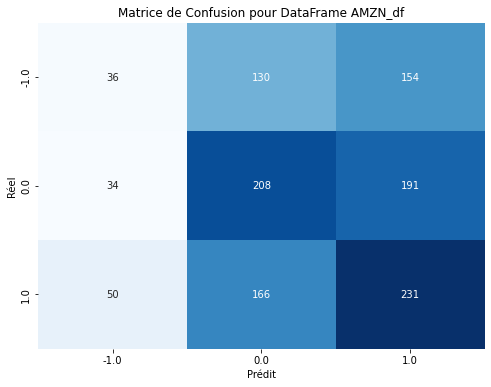


**********************************************************************
TSLA_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 42.35% |
| Hamming                | 57.65% |
| Macro-average Recall   | 35.07% |
| Macro-average F1 Score | 26.82% |
| Micro-average Recall   | 42.35% |
| Micro-average F1 Score | 42.35% |
+------------------------+--------+


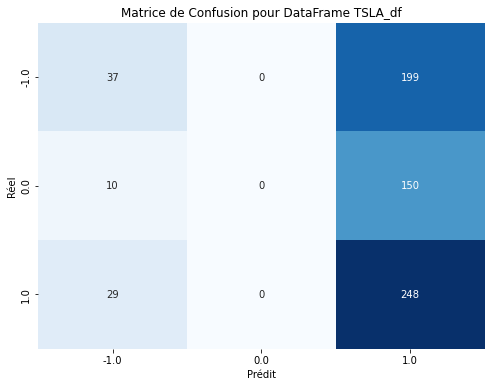


**********************************************************************
RMSPA_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 48.19% |
| Hamming                | 51.81% |
| Macro-average Recall   | 35.84% |
| Macro-average F1 Score | 29.08% |
| Micro-average Recall   | 48.19% |
| Micro-average F1 Score | 48.19% |
+------------------------+--------+


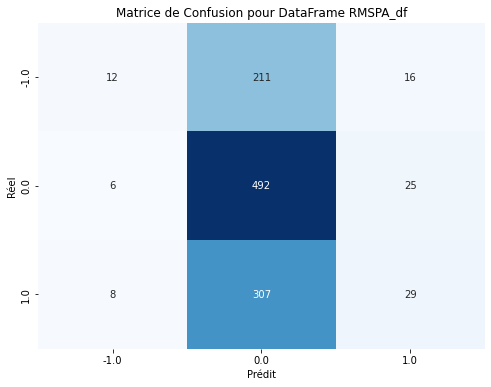


**********************************************************************
GE_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 51.67% |
| Hamming                | 48.33% |
| Macro-average Recall   | 42.08% |
| Macro-average F1 Score | 39.70% |
| Micro-average Recall   | 51.67% |
| Micro-average F1 Score | 51.67% |
+------------------------+--------+


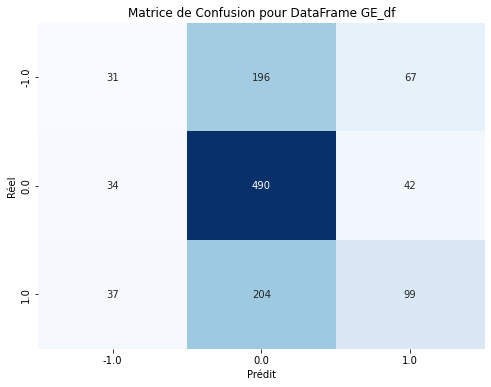


**********************************************************************
TTE_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 49.67% |
| Hamming                | 50.33% |
| Macro-average Recall   | 37.58% |
| Macro-average F1 Score | 32.26% |
| Micro-average Recall   | 49.67% |
| Micro-average F1 Score | 49.67% |
+------------------------+--------+


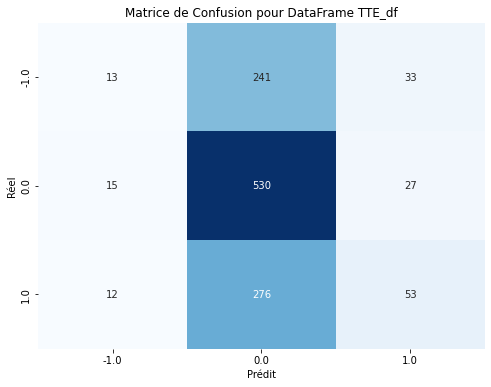

In [20]:
# Liste pour stocker les résultats de chaque modèle
from prettytable import PrettyTable
results_regression = []

# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():


       # Créez un DataFrame avec les colonnes sélectionnées
    data = df[selected_features + [target_column]]
    # Supprimer les lignes avec des valeurs manquantes
    data.dropna(inplace=True)


    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

    # Standardisez les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entraînez le modèle de régression logistique
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Évaluation de la performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')  
    f1 = f1_score(y_test, y_pred, average='weighted')  
    micro_recall = recall_score(y_test, y_pred, average='micro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    # Stocker les résultats dans la liste
    results_regression.append({
        'Model':'LogisticRegression',
        'DataFrame': key,
        'Accuracy': accuracy,
        'Hamming':hamming ,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'Recall': recall,
        'F1 Score': f1,
        'Macro-Recall': macro_recall,
        'Macro-F1': macro_f1,
        'Micro-Recall': micro_recall,
        'Micro-F1': micro_f1,
    })

# Affichage des résultats pour chaque dataframe
for result in results_regression:
    print('\n' + '*' * 70)
    print(result['DataFrame'])
    print('*' * 70)
    
    field_names = ['Metric', 'Value'] 
        # Create a PrettyTable object
    table = PrettyTable(field_names)

    # Add each metric value to the table
   
    table.add_row(['Accuracy', f"{result['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result['Micro-F1']:.2%}"])

    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)
    


    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion pour DataFrame {result["DataFrame"]}')
    plt.show()
# Affichage des résultats pour chaque dataframe sous forme de tableau
# table_headers = ['DataFrame', 'Accuracy', 'Hamming','Macro-average Recall','Macro-average F1 Score', 'Micro-average Recall', 'Micro-average F1 Score']
# table_rows = [[result['DataFrame'], result['Accuracy'], result['Hamming'], result['Macro-average Recall'], result['Macro-average F1 Score'],result['Micro-average Recall'],result['Micro-average F1 Score']] for result in results]

# # Afficher le tableau
# print(tabulate(table_rows, headers=table_headers, tablefmt='pretty'))

En général, l'analyse des performances des modèles appliqués à différents DataFrames révèle des résultats variables. Pour l'ensemble des DataFrames, les accuracies varient de 39.58% à 51.92%. La Hamming Loss, mesurant la discordance entre prédictions et étiquettes réelles, affiche des valeurs entre 48.08% et 60.42%. Les métriques macro-average, telles que le rappel et le score F1, démontrent des performances modérées, avec des valeurs allant de 35.07% à 42.08% et de 26.82% à 39.70%, respectivement. Les métriques micro-average présentent une performance globalement plus modérée, avec des valeurs entre 39.58% et 51.92%. Ces résultats soulignent la diversité des performances des modèles sur différents ensembles de données et suggèrent la nécessité d'une analyse approfondie et d'ajustements potentiels pour améliorer la robustesse du modèle.

### 2. SVM

In [21]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, hamming_loss

# Liste pour stocker les résultats de chaque modèle
result_SVM = []

# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():
    # Créez un DataFrame avec les colonnes sélectionnées
    data = df[selected_features + [target_column]]
    # Supprimer les lignes avec des valeurs manquantes
    data.dropna(inplace=True)

    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

    # Standardisez les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entraînez le modèle SVM
    model = SVC(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)

    # Évaluation de la performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    macro_recall = recall_score(y_test, y_pred, average='macro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_recall = recall_score(y_test, y_pred, average='micro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')


    # Stocker les résultats dans la liste
    result_SVM.append({
        'Model':'SVM',
        'DataFrame': key,
        'Accuracy': accuracy,
        'Hamming': hamming,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'Macro-Recall': macro_recall,
        'Macro-F1' :macro_f1,
        'Micro-Recall': micro_recall,
        'Micro-F1':micro_f1
        
    })




In [22]:

for result_rf in result_SVM :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")

    # Afficher les résultats sous forme de tableau
#     table_headers1 = [ 'Accuracy', 'Hamming Loss', 'Macro Recall','Macro F1 Score','Micro Recall','Micro F1 Score' ]
#     table_headers2 = [ 'Best Hyperparameters']
    table_rows = []
    field_names = ['Metric', 'Value'] 
        # Create a PrettyTable object
    table = PrettyTable(field_names)
#     t=PrettyTable(field_names)
    # Add each metric value to the table
   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 53.33% |
| Hamming                | 46.67% |
| Macro-average Recall   | 38.50% |
| Macro-average F1 Score | 33.10% |
| Micro-average Recall   | 53.33% |
| Micro-average F1 Score | 53.33% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 43.67% |
| Hamming                | 56.33% |
| Macro-average Recall   | 41.09% |
| Macro-average F1 Score | 39.82% |
| Micro-average Recall   | 43.67% |
| Micro-average F1 Score |

### 3. K plus proches voisins (KNN)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hamming_loss, recall_score, f1_score

# Liste pour stocker les résultats de chaque modèle k-NN
result_knn = []

def train_knn_model(X_train, y_train, X_test, y_test, key):
    # Standardisation des features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Définition des hyperparamètres à rechercher
    param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

    # Recherche par grille pour trouver les meilleurs hyperparamètres
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Affichage des meilleurs hyperparamètres et du meilleur score
    print("Meilleurs hyperparamètres :", grid_search.best_params_)
    print("Meilleur score :", grid_search.best_score_)

    # Entraînement du modèle k-NN avec les meilleurs hyperparamètres
    best_knn_model = grid_search.best_estimator_
    best_knn_model.fit(X_train_scaled, y_train)

    # Prédictions sur l'ensemble de test
    y_pred_knn = best_knn_model.predict(X_test_scaled)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_pred_knn)
    conf_matrix = confusion_matrix(y_test, y_pred_knn)
    class_report = classification_report(y_test, y_pred_knn)
    hamming = hamming_loss(y_test, y_pred_knn)
    macro_recall = recall_score(y_test, y_pred_knn, average='macro')
    macro_f1 = f1_score(y_test, y_pred_knn, average='macro')
    micro_recall = recall_score(y_test, y_pred_knn, average='micro')
    micro_f1 = f1_score(y_test, y_pred_knn, average='micro')

    # Stocker les résultats dans la liste
    result_knn.append({
        'Model':' K plus proches voisins(KNN)',
        'DataFrame': key,
        'Accuracy': accuracy,
        'Hamming': hamming,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'Macro-Recall': macro_recall,
        'Macro-F1': macro_f1,
        'Micro-Recall': micro_recall,
        'Micro-F1': micro_f1
    })

# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():
    # Créez un DataFrame avec les colonnes sélectionnées
    data = df[selected_features + [target_column]]
    # Supprimer les lignes avec des valeurs manquantes
    data.dropna(inplace=True)

    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

    print(f"\nTraining k-NN model for DataFrame {key}:")
    train_knn_model(X_train, y_train, X_test, y_test, key)



Training k-NN model for DataFrame MSFT_df:
Meilleurs hyperparamètres : {'n_neighbors': 11}
Meilleur score : 0.4842676833507126

Training k-NN model for DataFrame AMZN_df:
Meilleurs hyperparamètres : {'n_neighbors': 3}
Meilleur score : 0.45884428223844276

Training k-NN model for DataFrame TSLA_df:
Meilleurs hyperparamètres : {'n_neighbors': 3}
Meilleur score : 0.4897807591396509

Training k-NN model for DataFrame RMSPA_df:
Meilleurs hyperparamètres : {'n_neighbors': 5}
Meilleur score : 0.5246496408211263

Training k-NN model for DataFrame GE_df:
Meilleurs hyperparamètres : {'n_neighbors': 5}
Meilleur score : 0.5536555005213764

Training k-NN model for DataFrame TTE_df:
Meilleurs hyperparamètres : {'n_neighbors': 3}
Meilleur score : 0.5148978971150504


In [24]:

for result_rf in result_knn :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")
    table_rows = []
    field_names = ['Metric', 'Value'] 
    table = PrettyTable(field_names)   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 52.08% |
| Hamming                | 47.92% |
| Macro-average Recall   | 43.80% |
| Macro-average F1 Score | 43.21% |
| Micro-average Recall   | 52.08% |
| Micro-average F1 Score | 52.08% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 47.08% |
| Hamming                | 52.92% |
| Macro-average Recall   | 47.94% |
| Macro-average F1 Score | 47.07% |
| Micro-average Recall   | 47.08% |
| Micro-average F1 Score |

### 4 . Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, hamming_loss
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Liste pour stocker les résultats de chaque modèle avec Grid Search, y compris Hamming Loss
results_rf_grid_search_hamming = []


# Définir la grille des hyperparamètres à rechercher pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
key, df = next(iter(list_choice.items()))
# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():

    # Créez un DataFrame avec les colonnes sélectionnées
    data = df[selected_features + [target_column]]
    # Supprimer les lignes avec des valeurs manquantes
    data.dropna(inplace=True)

    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

    # Création d'un modèle Random Forest
    rf_model = RandomForestClassifier()

    # Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
    grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
    grid_search_rf.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred_rf = grid_search_rf.predict(X_test)

    # Évaluation du modèle
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    class_report_rf = classification_report(y_test, y_pred_rf)
    hamming_rf = hamming_loss(y_test, y_pred_rf)
    macro_recall_rf = recall_score(y_test, y_pred_rf, average='macro')
    macro_f1_rf = f1_score(y_test, y_pred_rf, average='macro')
    micro_recall_rf = recall_score(y_test, y_pred_rf, average='micro')
    micro_f1_rf = f1_score(y_test, y_pred_rf, average='micro')

    # Add the macro and micro averages to your results dictionary
    results_rf_grid_search_hamming.append({
        'Model':'Random Forest',
        'DataFrame': key,
        'Best Hyperparameters': grid_search_rf.best_params_,
        'Accuracy': accuracy_rf,
        'Classification Report': class_report_rf,
        'Hamming': hamming_rf,
        
        'Macro-Recall': macro_recall_rf,
        'Macro-F1': macro_f1_rf,
       
        'Micro-Recall': micro_recall_rf,
        'Micro-F1': micro_f1_rf,
    })
    
    
  

Evaluation

In [39]:

for result_rf in results_rf_grid_search_hamming :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")

    # Afficher les résultats sous forme de tableau
#     table_headers1 = [ 'Accuracy', 'Hamming Loss', 'Macro Recall','Macro F1 Score','Micro Recall','Micro F1 Score' ]
#     table_headers2 = [ 'Best Hyperparameters']
    table_rows = []
    field_names = ['Metric', 'Value'] 
        # Create a PrettyTable object
    table = PrettyTable(field_names)
#     t=PrettyTable(field_names)
    # Add each metric value to the table
    print(result_rf['Best Hyperparameters'])
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 63.83% |
| Hamming                | 36.17% |
| Macro-average Recall   | 57.34% |
| Macro-average F1 Score | 59.11% |
| Micro-average Recall   | 63.83% |
| Micro-average F1 Score | 63.83% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 59.

### 5. Gradient boosting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss, confusion_matrix, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Initialize result list
result_gradientb = []

def optimize_gb_model(X_train, y_train, X_test, y_test, key):
    # Standardisation des features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Définir les hyperparamètres à optimiser
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6]
    }

    # Initialiser le modèle Gradient Boosting
    gb_model = GradientBoostingClassifier(random_state=42)

    # Initialiser la recherche d'hyperparamètres
    random_search = RandomizedSearchCV(gb_model, param_dist, n_iter=10, cv=5, random_state=42)

    # Effectuer la recherche d'hyperparamètres sur les données d'entraînement
    random_search.fit(X_train_scaled, y_train)

    # Afficher les meilleurs hyperparamètres et le meilleur score
    print("Meilleurs hyperparamètres après recherche aléatoire :", random_search.best_params_)
    print("Meilleur score après recherche aléatoire :", random_search.best_score_)

    # Prédictions sur l'ensemble de test avec les meilleurs hyperparamètres
    y_pred_gb_optimized = random_search.predict(X_test_scaled)

    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred_gb_optimized)
    hamming = hamming_loss(y_test, y_pred_gb_optimized)
    conf_matrix = confusion_matrix(y_test, y_pred_gb_optimized)
    class_report = classification_report(y_test, y_pred_gb_optimized)
    macro_recall = recall_score(y_test, y_pred_gb_optimized, average='macro')
    macro_f1 = f1_score(y_test, y_pred_gb_optimized, average='macro')
    micro_recall = recall_score(y_test, y_pred_gb_optimized, average='micro')
    micro_f1 = f1_score(y_test, y_pred_gb_optimized, average='micro')

    # Append results to the list
    result_gradientb.append({
        'Model':'Gradient boosting',
        'DataFrame': key,
        'Accuracy': accuracy,
        'Hamming': hamming,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'Macro-Recall': macro_recall,
        'Macro-F1': macro_f1,
        'Micro-Recall': micro_recall,
        'Micro-F1': micro_f1
    })

# Parcourir chaque dataframe dans list_choice
for key, df in list_choice.items():
    # Créez un DataFrame avec les colonnes sélectionnées
    data = df[selected_features + [target_column]]
    # Supprimer les lignes avec des valeurs manquantes
    data.dropna(inplace=True)

    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

    print(f"\nOptimizing Gradient Boosting model for DataFrame {key}:")
    optimize_gb_model(X_train, y_train, X_test, y_test, key)


In [40]:

for result_rf in result_gradientb :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")
    table_rows = []
    field_names = ['Metric', 'Value'] 
    table = PrettyTable(field_names)   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 57.08% |
| Hamming                | 42.92% |
| Macro-average Recall   | 50.57% |
| Macro-average F1 Score | 51.44% |
| Micro-average Recall   | 57.08% |
| Micro-average F1 Score | 57.08% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 54.33% |
| Hamming                | 45.67% |
| Macro-average Recall   | 53.67% |
| Macro-average F1 Score | 53.77% |
| Micro-average Recall   | 54.33% |
| Micro-average F1 Score |

### 6.LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Liste pour stocker les résultats de chaque modèle LSTM
results_LSTM = []

def train_lstm_model(df, features, key):
    # Définir les caractéristiques (X) et la cible (y)
    X = df[features].values
    y = df['Trend'].values

    # Encoder les étiquettes en utilisant LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Normaliser les données
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Diviser les données en ensembles d'entraînement et de test avec stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Remodeler les données pour les rendre compatibles avec LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Convertir les étiquettes en encodage one-hot (si nécessaire)
    num_classes = len(np.unique(y))
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)

    # Créer le modèle LSTM
    model = Sequential()
    model.add(LSTM(300, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entraîner le modèle et enregistrer l'historique de l'entraînement
    history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))

    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
    print(f'\nTest Accuracy: {test_accuracy}')

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Convertir les prédictions en classe binaire (0, 1, 2) plutôt qu'en encodage one-hot
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_onehot, axis=1)

    # Calcul de l'indice de Hamming
    hamming = hamming_loss(y_test_classes, y_pred_classes)
    print(f'\nHamming Loss: {hamming}')

    # Calcul du micro-average (précision, rappel, f1-score)
    micro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='micro')

    # Calcul du macro-average (précision, rappel, f1-score)
    macro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='macro')
   

    results_LSTM.append({
        'Model':'LSTM',
        'DataFrame': key,
        'Accuracy': test_accuracy,
        'Hamming': hamming,
       
        'Micro-Recall': micro_avg[1],
        'Micro-F1': micro_avg[2],
    
        'Macro-Recall': macro_avg[1],
        'Macro-F1': macro_avg[2]
    })

# Appliquer la fonction à chaque dataframe de la liste
for key, df in list_choice.items():
    print(f'\nTraining LSTM Model for DataFrame {key}...')
    train_lstm_model(df, selected_features, key)


In [41]:

for result_rf in results_LSTM :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")
    table_rows = []
    field_names = ['Metric', 'Value'] 
    table = PrettyTable(field_names)   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

        
    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 49.42% |
| Hamming                | 50.58% |
| Macro-average Recall   | 34.85% |
| Macro-average F1 Score | 27.57% |
| Micro-average Recall   | 49.42% |
| Micro-average F1 Score | 49.42% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 40.83% |
| Hamming                | 59.17% |
| Macro-average Recall   | 38.41% |
| Macro-average F1 Score | 32.27% |
| Micro-average Recall   | 40.83% |
| Micro-average F1 Score |

### 7. Réseaux de neurones récurrents (RNN)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Liste pour stocker les résultats de chaque modèle RNN
results_RNN = []

def train_rnn_model(df, features, key):
    # Définir les caractéristiques (X) et la cible (y)
    X = df[features].values
    y = df['Trend'].values

    # Encoder les étiquettes en utilisant LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Normaliser les données
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Diviser les données en ensembles d'entraînement et de test avec stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Remodeler les données pour les rendre compatibles avec RNN
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Convertir les étiquettes en encodage one-hot (si nécessaire)
    num_classes = len(np.unique(y))
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)

    # Créer le modèle RNN
    model = Sequential()
    model.add(SimpleRNN(300, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entraîner le modèle et enregistrer l'historique de l'entraînement
    history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))

    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
    print(f'\nTest Accuracy: {test_accuracy}')

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Convertir les prédictions en classe binaire (0, 1, 2) plutôt qu'en encodage one-hot
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_onehot, axis=1)

    # Calcul de l'indice de Hamming
    hamming = hamming_loss(y_test_classes, y_pred_classes)
    

    # Calcul du micro-average (précision, rappel, f1-score)
    micro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='micro')
    

    # Calcul du macro-average (précision, rappel, f1-score)
    macro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='macro')
    print(f'\nMacro-average Precision: {macro_avg[0]}')
    print(f'Macro-average Recall: {macro_avg[1]}')
    print(f'Macro-average F1 Score: {macro_avg[2]}')

    results_RNN.append({
        'Model':'RNN',
        'DataFrame': key,
        'Accuracy': test_accuracy,
        'Hamming': hamming,
    
        'Micro-Recall': micro_avg[1],
        'Micro-F1': micro_avg[2],
    
        'Macro-Recall': macro_avg[1],
        'Macro-F1': macro_avg[2]
    })

# Appliquer la fonction à chaque dataframe de la liste
for key, df in list_choice.items():
    print(f'\nTraining RNN Model for DataFrame {key}...')
    train_rnn_model(df, selected_features, key)


In [42]:

for result_rf in results_RNN :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")
    table_rows = []
    field_names = ['Metric', 'Value'] 
    table = PrettyTable(field_names)   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

        
    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 49.50% |
| Hamming                | 50.50% |
| Macro-average Recall   | 35.36% |
| Macro-average F1 Score | 28.89% |
| Micro-average Recall   | 49.50% |
| Micro-average F1 Score | 49.50% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 41.67% |
| Hamming                | 58.33% |
| Macro-average Recall   | 39.27% |
| Macro-average F1 Score | 33.81% |
| Micro-average Recall   | 41.67% |
| Micro-average F1 Score |

### 8.Réseaux de neurones convolutifs (CNN) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Liste pour stocker les résultats de chaque modèle CNN
results_CNN = []

def train_cnn_model(df, features, key):
    # Définir les caractéristiques (X) et la cible (y)
    X = df[features].values
    y = df['Trend'].values

    # Encoder les étiquettes en utilisant LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Normaliser les données
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)

    # Diviser les données en ensembles d'entraînement et de test avec stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Remodeler les données pour les rendre compatibles avec CNN
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Convertir les étiquettes en encodage one-hot (si nécessaire)
    num_classes = len(np.unique(y))
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)

    # Créer le modèle CNN
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entraîner le modèle et enregistrer l'historique de l'entraînement
    history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))

    # Afficher les courbes d'apprentissage (loss et accuracy) au fil des époques
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
    print(f'\nTest Accuracy: {test_accuracy}')

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Convertir les prédictions en classe binaire (0, 1, 2) plutôt qu'en encodage one-hot
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_onehot, axis=1)

    # Calcul de l'indice de Hamming
    hamming = hamming_loss(y_test_classes, y_pred_classes)

    # Calcul du micro-average (précision, rappel, f1-score)
    micro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='micro')

    # Calcul du macro-average (précision, rappel, f1-score)
    macro_avg = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='macro')
    

   
    results_CNN.append({
        'Model':'CNN',
        'DataFrame': key,
        'Accuracy': test_accuracy,
        'Hamming': hamming,
    
        'Micro-Recall': micro_avg[1],
        'Micro-F1': micro_avg[2],
   
        'Macro-Recall': macro_avg[1],
        'Macro-F1': macro_avg[2]
    })

# Appliquer la fonction à chaque dataframe de la liste
for key, df in list_choice.items():
    print(f'\nTraining CNN Model for DataFrame {key}...')
    train_cnn_model(df, selected_features, key)


In [50]:

for result_rf in results_CNN :

   
    print(f"\n{'*' * 70}\nResults for {result_rf['DataFrame']}\n{'*' * 70}")
    table_rows = []
    field_names = ['Metric', 'Value'] 
    table = PrettyTable(field_names)   
    table.add_row(['Accuracy', f"{result_rf['Accuracy']:.2%}"])
    table.add_row(['Hamming', f"{result_rf['Hamming']:.2%}"])
    table.add_row(['Macro-average Recall', f"{result_rf['Macro-Recall']:.2%}"])
    table.add_row(['Macro-average F1 Score', f"{result_rf['Macro-F1']:.2%}"])
    table.add_row(['Micro-average Recall', f"{result_rf['Micro-Recall']:.2%}"])
    table.add_row(['Micro-average F1 Score', f"{result_rf['Micro-F1']:.2%}"])

        
    # Style the table
    table.align['Metric'] = 'l'
    table.align['Value'] = 'r'

    # Print the table
    print(table)


**********************************************************************
Results for MSFT_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 49.67% |
| Hamming                | 50.33% |
| Macro-average Recall   | 34.40% |
| Macro-average F1 Score | 25.65% |
| Micro-average Recall   | 49.67% |
| Micro-average F1 Score | 49.67% |
+------------------------+--------+

**********************************************************************
Results for AMZN_df
**********************************************************************
+------------------------+--------+
| Metric                 |  Value |
+------------------------+--------+
| Accuracy               | 41.08% |
| Hamming                | 58.92% |
| Macro-average Recall   | 39.82% |
| Macro-average F1 Score | 39.10% |
| Micro-average Recall   | 41.08% |
| Micro-average F1 Score |

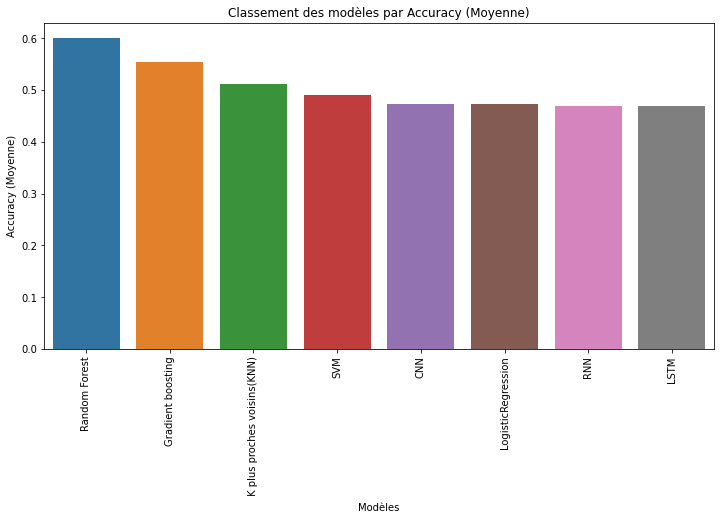

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Liste pour stocker les résultats de chaque modèle
df_results = [results_regression, result_gradientb, results_rf_grid_search_hamming, result_SVM, result_knn, results_LSTM, results_RNN, results_CNN]

# Convertir les résultats en DataFrames
dfs = [pd.DataFrame(result) for result in df_results]

# Concaténer les DataFrames en un seul
df_concatenated = pd.concat(dfs, ignore_index=True)

# Calculer la moyenne de l'Accuracy pour chaque modèle
df_model_mean = df_concatenated.groupby('Model')['Accuracy'].mean().reset_index()

df_model_mean_sorted = df_model_mean.sort_values(by='Accuracy', ascending=False)

# Visualisation du classement trié
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=df_model_mean_sorted)
plt.title('Classement des modèles par Accuracy (Moyenne)')
plt.xlabel('Modèles')
plt.ylabel('Accuracy (Moyenne)')
plt.xticks(rotation=90)
plt.show()


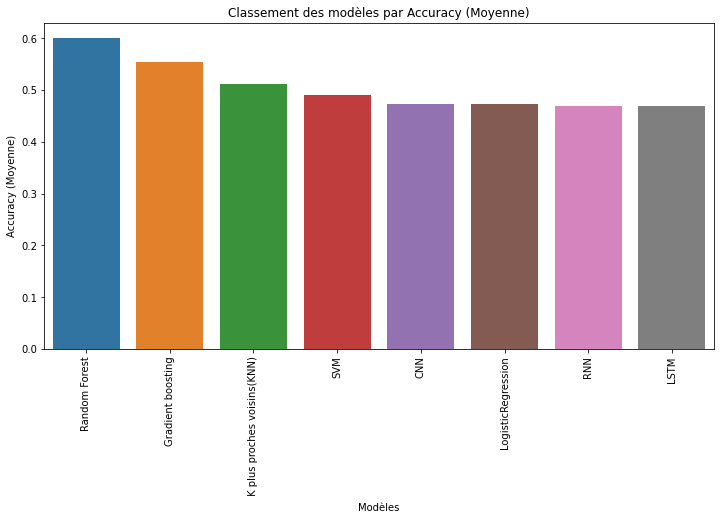

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Liste pour stocker les résultats de chaque modèle
df_results = [results_regression, result_gradientb, results_rf_grid_search_hamming, result_SVM, result_knn, results_LSTM, results_RNN, results_CNN]

# Convertir les résultats en DataFrames
dfs = [pd.DataFrame(result) for result in df_results]

# Calculer la moyenne de l'Accuracy pour chaque modèle
df_model_mean = df_concatenated.groupby('Model')['Accuracy'].mean().reset_index()
df_model_mean_sorted = df_model_mean.sort_values(by='Accuracy', ascending=False)

# Visualisation du classement trié
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=df_model_mean_sorted)
plt.title('Classement des modèles par Accuracy (Moyenne)')
plt.xlabel('Modèles')
plt.ylabel('Accuracy (Moyenne)')
plt.xticks(rotation=90)
plt.show()

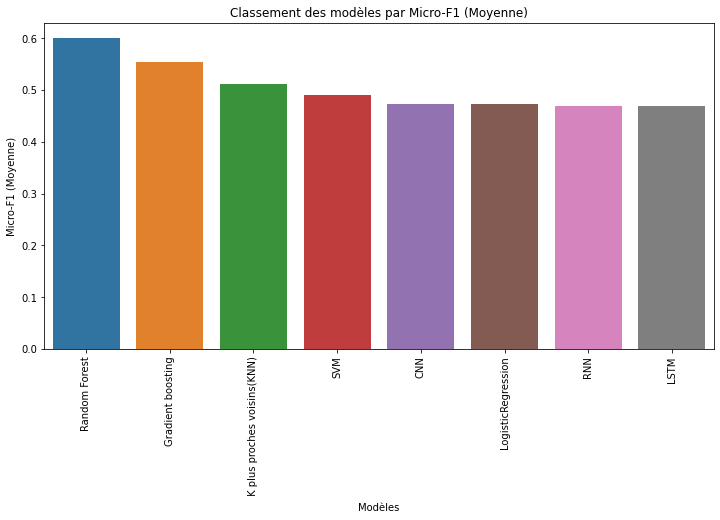

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Liste pour stocker les résultats de chaque modèle
df_results = [results_regression, result_gradientb, results_rf_grid_search_hamming, result_SVM, result_knn, results_LSTM, results_RNN, results_CNN]

# Convertir les résultats en DataFrames
dfs = [pd.DataFrame(result) for result in df_results]

# Calculer la moyenne de l'Accuracy pour chaque modèle
df_model_mean = df_concatenated.groupby('Model')['Micro-F1'].mean().reset_index()
df_model_mean_sorted = df_model_mean.sort_values(by='Micro-F1', ascending=False)

# Visualisation du classement trié
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Micro-F1', data=df_model_mean_sorted)
plt.title('Classement des modèles par Micro-F1 (Moyenne)')
plt.xlabel('Modèles')
plt.ylabel('Micro-F1 (Moyenne)')
plt.xticks(rotation=90)
plt.show()
